In [1]:
import numpy as np
import jax.numpy as jnp
import torch
import mne
import os
import matplotlib
%matplotlib widget
#matplotlib.use('tkagg')
import matplotlib.pyplot as plt
#from remote_plot import plt
from main_functions.DHT import dataDHT
from main_functions.utils import NormalizeData
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.svm import SVC
from sklearn.metrics import classification_report
#%matplotlib qt
#matplotlib.use('Qt5Agg')
#print(matplotlib.get_backend()) 

np.int = int
np.bool = bool
np.object = object
from braindecode.datasets import BCICompetitionIVDataset4, BNCI2014001
from braindecode.preprocessing import create_windows_from_events
from braindecode.util import set_random_seeds
from braindecode.models import ShallowFBCSPNet, EEGNetv4, EEGNetv1, EEGResNet, EEGInception
from skorch.callbacks import LRScheduler
from braindecode import EEGClassifier

In [2]:
# Specify the path to your MNE_DATA directory
mne_data_path = '/home/natalia/Git_Projects/PhD/data'
os.environ['MNE_DATA'] = mne_data_path
subject_id = 1
dataset = BNCI2014001(subject_ids=[subject_id])

48 events found on stim channel stim
Event IDs: [1 2 3 4]
48 events found on stim channel stim
Event IDs: [1 2 3 4]
48 events found on stim channel stim
Event IDs: [1 2 3 4]
48 events found on stim channel stim
Event IDs: [1 2 3 4]
48 events found on stim channel stim
Event IDs: [1 2 3 4]
48 events found on stim channel stim
Event IDs: [1 2 3 4]
48 events found on stim channel stim
Event IDs: [1 2 3 4]
48 events found on stim channel stim
Event IDs: [1 2 3 4]
48 events found on stim channel stim
Event IDs: [1 2 3 4]
48 events found on stim channel stim
Event IDs: [1 2 3 4]
48 events found on stim channel stim
Event IDs: [1 2 3 4]
48 events found on stim channel stim
Event IDs: [1 2 3 4]


In [3]:
raw = dataset.datasets[0].raw

# Get the channel names
channel_names = raw.info['ch_names']
print(f'Channel names: {channel_names}')


# Get only the signals, ignoring the targets
signal_channels = [ch for ch in channel_names if not ch.startswith(('EOG1', 'EOG2', 'EOG3', 'stim'))]
print(f'Signal channels: {signal_channels}')

# Create a new raw object with only signal channels
raw_signals = raw.copy().pick(signal_channels)

Channel names: ['Fz', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'P1', 'Pz', 'P2', 'POz', 'EOG1', 'EOG2', 'EOG3', 'stim']
Signal channels: ['Fz', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'P1', 'Pz', 'P2', 'POz']


Data shape: (22, 96735)
Number of channels: 22
Number of sample points: 96735
Using matplotlib as 2D backend.


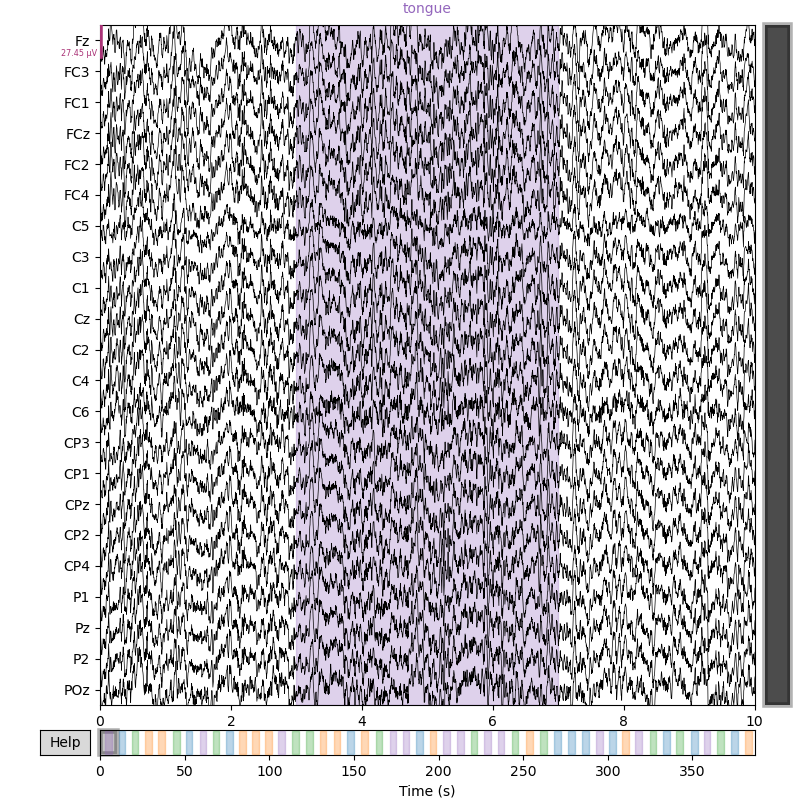

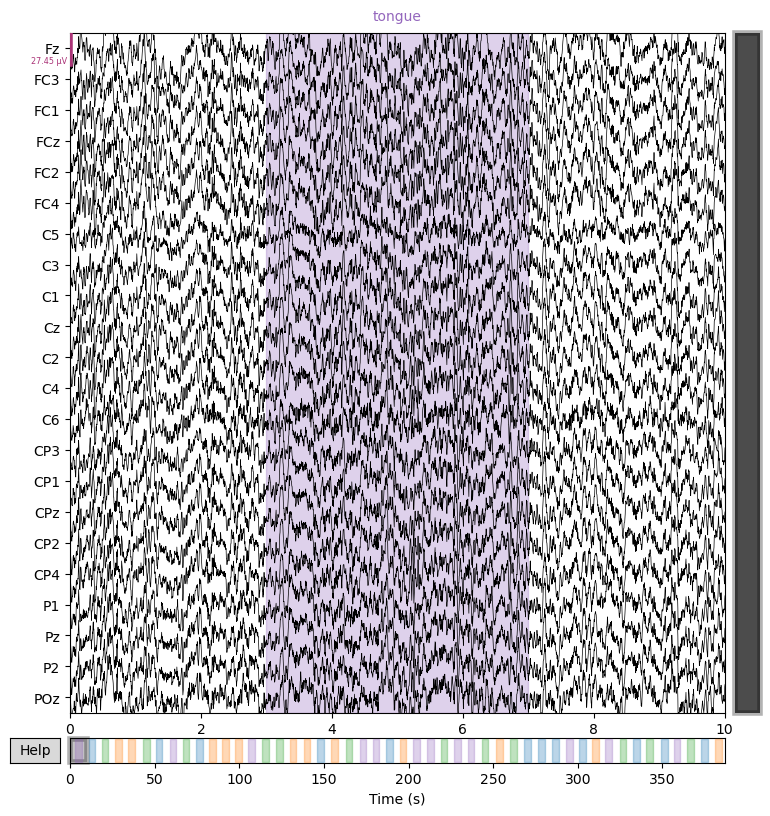

In [4]:
#mne.set_config('MNE_BROWSER_BACKEND', 'matplotlib')
#mne.viz.use_browser_backend('matplotlib')
#%matplotlib inline
#%matplotlib widget
# Get the data as a numpy array
data, times = raw_signals[:]
print(f'Data shape: {data.shape}')
print(f'Number of channels: {data.shape[0]}')
print(f'Number of sample points: {data.shape[1]}')

# Plot the raw data
raw_signals.plot(n_channels=22, scalings='auto', title='ECoG Data')
#plt.show()

Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).


/tmp/ipykernel_1369643/876665953.py:1: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  raw_signals.compute_psd(method='welch').plot(show=False)


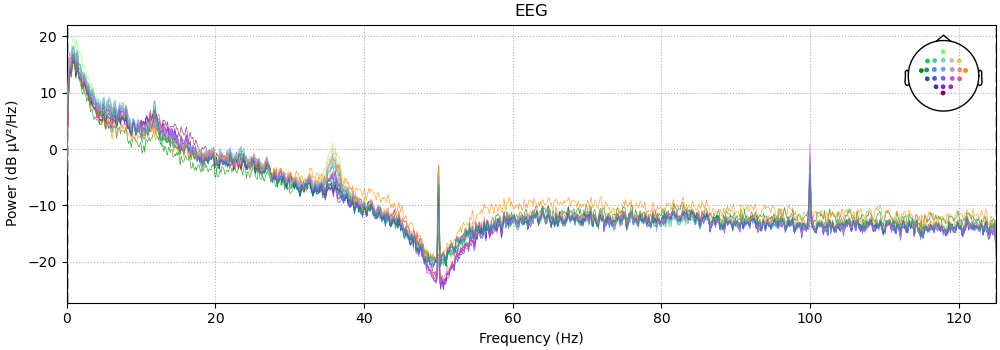

In [6]:
raw_signals.compute_psd(method='welch').plot(show=False)
plt.show()

Effective window size : 8.192 (s)


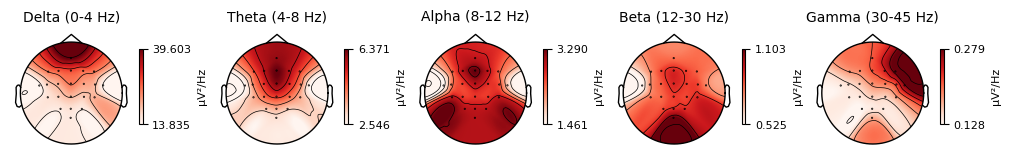

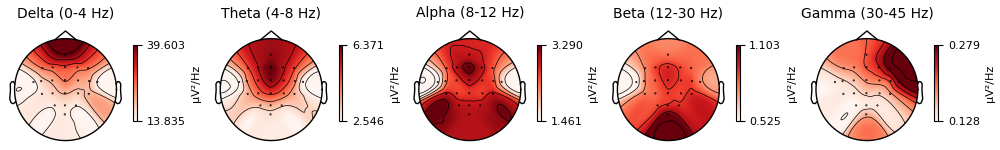

In [8]:
raw_signals.compute_psd(method='welch').plot_topomap(show=False)

In [9]:
def snr_spectrum(psd, noise_n_neighbor_freqs=1, noise_skip_neighbor_freqs=1):
    """Compute SNR spectrum from PSD spectrum using convolution.

    Parameters
    ----------
    psd : ndarray, shape ([n_trials, n_channels,] n_frequency_bins)
        Data object containing PSD values. Works with arrays as produced by
        MNE's PSD functions or channel/trial subsets.
    noise_n_neighbor_freqs : int
        Number of neighboring frequencies used to compute noise level.
        increment by one to add one frequency bin ON BOTH SIDES
    noise_skip_neighbor_freqs : int
        set this >=1 if you want to exclude the immediately neighboring
        frequency bins in noise level calculation

    Returns
    -------
    snr : ndarray, shape ([n_trials, n_channels,] n_frequency_bins)
        Array containing SNR for all epochs, channels, frequency bins.
        NaN for frequencies on the edges, that do not have enough neighbors on
        one side to calculate SNR.
    """
    # Construct a kernel that calculates the mean of the neighboring
    # frequencies
    averaging_kernel = np.concatenate(
        (
            np.ones(noise_n_neighbor_freqs),
            np.zeros(2 * noise_skip_neighbor_freqs + 1),
            np.ones(noise_n_neighbor_freqs),
        )
    )
    averaging_kernel /= averaging_kernel.sum()

    # Calculate the mean of the neighboring frequencies by convolving with the
    # averaging kernel.
    mean_noise = np.apply_along_axis(
        lambda psd_: np.convolve(psd_, averaging_kernel, mode="valid"), axis=-1, arr=psd
    )

    # The mean is not defined on the edges so we will pad it with nas. The
    # padding needs to be done for the last dimension only so we set it to
    # (0, 0) for the other ones.
    edge_width = noise_n_neighbor_freqs + noise_skip_neighbor_freqs
    pad_width = [(0, 0)] * (mean_noise.ndim - 1) + [(edge_width, edge_width)]
    mean_noise = np.pad(mean_noise, pad_width=pad_width, constant_values=np.nan)

    return psd / mean_noise

In [10]:
psds, freqs = raw_signals.compute_psd(method='welch').get_data(return_freqs=True)

Effective window size : 8.192 (s)


In [11]:
psds_ = psds.reshape(1,22,1025)

In [12]:
snrs = snr_spectrum(psds_, noise_n_neighbor_freqs=1, noise_skip_neighbor_freqs=1)

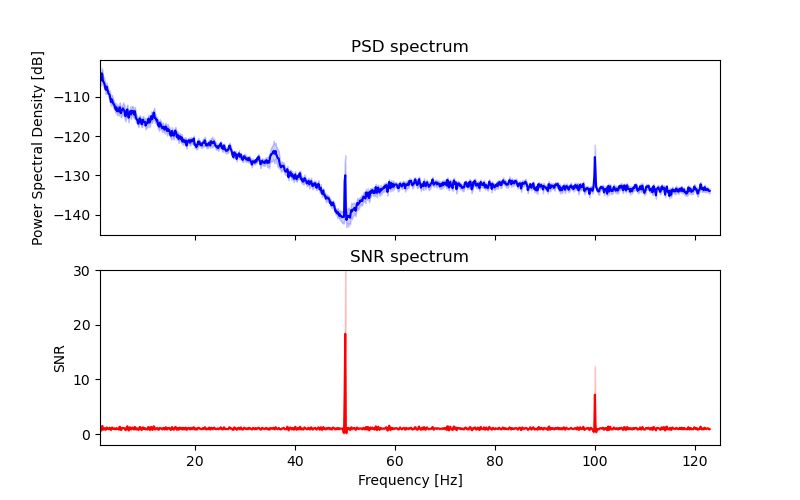

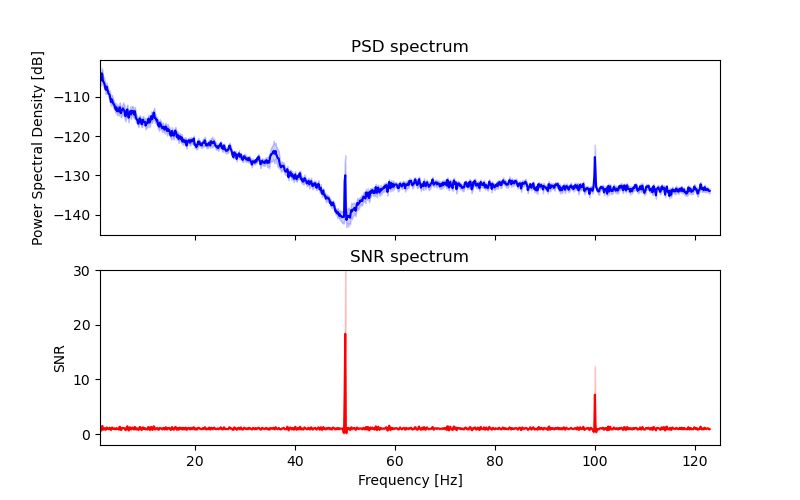

In [13]:
tmin = 1.0
tmax = 20.0
fmin = 1.0
fmax = 125.0
sfreq = raw_signals.info["sfreq"]


fig, axes = plt.subplots(2, 1, sharex="all", sharey="none", figsize=(8, 5))
freq_range = range(
    np.where(np.floor(freqs) == 1.0)[0][0], np.where(np.ceil(freqs) == fmax - 1)[0][0]
)

psds_plot = 10 * np.log10(psds_)
psds_mean = psds_plot.mean(axis=(0, 1))[freq_range]
psds_std = psds_plot.std(axis=(0, 1))[freq_range]
axes[0].plot(freqs[freq_range], psds_mean, color="b")
axes[0].fill_between(
    freqs[freq_range], psds_mean - psds_std, psds_mean + psds_std, color="b", alpha=0.2
)
axes[0].set(title="PSD spectrum", ylabel="Power Spectral Density [dB]")

# SNR spectrum
snr_mean = snrs.mean(axis=(0, 1))[freq_range]
snr_std = snrs.std(axis=(0, 1))[freq_range]

axes[1].plot(freqs[freq_range], snr_mean, color="r")
axes[1].fill_between(
    freqs[freq_range], snr_mean - snr_std, snr_mean + snr_std, color="r", alpha=0.2
)
axes[1].set(
    title="SNR spectrum",
    xlabel="Frequency [Hz]",
    ylabel="SNR",
    ylim=[-2, 30],
    xlim=[fmin, fmax],
)
fig.show()

In [24]:
raw.info

<Info | 8 non-empty values
 bads: []
 ch_names: Fz, FC3, FC1, FCz, FC2, FC4, C5, C3, C1, Cz, C2, C4, C6, CP3, ...
 chs: 22 EEG, 3 EOG, 1 Stimulus
 custom_ref_applied: False
 dig: 25 items (3 Cardinal, 22 EEG)
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: unspecified
 nchan: 26
 projs: []
 sfreq: 250.0 Hz
>

In [25]:
labels = mne.find_events(raw)

48 events found on stim channel stim
Event IDs: [1 2 3 4]


#### Training example

In [14]:
trial_start_offset_seconds = -0.5
# Extract sampling frequency, check that they are same in all datasets
sfreq = dataset.datasets[0].raw.info["sfreq"]
assert all([ds.raw.info["sfreq"] == sfreq for ds in dataset.datasets])
# Calculate the window start offset in samples.
trial_start_offset_samples = int(trial_start_offset_seconds * sfreq)

# Create windows using braindecode function for this. It needs parameters to
# define how windows should be used.
windows_dataset = create_windows_from_events(
    dataset,
    trial_start_offset_samples=trial_start_offset_samples,
    trial_stop_offset_samples=int(0*sfreq),
    preload=True,
    picks=signal_channels
)

Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']


/home/natalia/miniforge-pypy3/envs/PhD_test/lib/python3.12/site-packages/braindecode/preprocessing/windowers.py:130: UserWarning: Using reject or picks or flat or dropping bad windows means mne Epochs are created, which will be substantially slower and may be deprecated in the future.
  warnings.warn('Using reject or picks or flat or dropping bad windows means '


In [15]:
splitted = windows_dataset.split("session")
train_set = splitted["session_T"]  # Session train
test_set = splitted["session_E"]  # Session evaluation

In [16]:
def filtro_CAR(X, axis=0):
  return X - np.mean(X,axis=axis,keepdims=True)

In [17]:
wdata_ = []
#wlabels_ = []
for x, y, z in train_set:
    wdata_.append(x)
wdata = filtro_CAR(np.array(wdata_), axis=1)
wlabels = train_set.get_metadata().target.values
wdhtdata = NormalizeData(dataDHT(wdata))

wdatatest_ = []
for x, y, z in test_set:
    wdatatest_.append(x)
wdatatest = filtro_CAR(np.array(wdatatest_), axis=1)
wlabelstest = test_set.get_metadata().target.values
wdhtdatatest = NormalizeData(dataDHT(wdatatest))

CUDA backend failed to initialize: INTERNAL: no supported devices found for platform CUDA.(Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [18]:
train_data = []
test_data = []
for i in range(len(train_set)):
    x, y, z = train_set[i]
    m, n, p = test_set[i]
    train_data.append(x)
    test_data.append(m) 

In [19]:
np.array(train_data).shape

(288, 22, 1125)

In [20]:
np.expand_dims(np.array(train_data), axis=3).shape

(288, 22, 1125, 1)

In [21]:
wdata.shape

(288, 22, 1125)

In [161]:
1250/250

5.0

In [155]:
1125/250

4.5

In [22]:
dic_labels = {0:'left hand', 1:'right hand', 2:'feet', 3:'tongue'}

# Create a simple plot

for example in wlabels[:4]:
    fig = go.Figure()
    t= jnp.arange(0,wdata.shape[2]) / sfreq # plot in time
    f = jnp.arange(0,len(wdata)) * (sfreq/len(wdata))
    fig.add_trace(go.Scatter(x=f, y=wdhtdata[example,0,:], mode='lines', name='With CAR')) #np.reshape(signal, (signal.shape[1]))

    # Update layout
    fig.update_layout(
        title=f'{dic_labels[example]}',
        xaxis=dict(title='Frequency (Hz)'),
        yaxis=dict(title='Amplitude'),
        template='plotly_white'
    )
    # Show the plot
    fig.show()

4 Hz


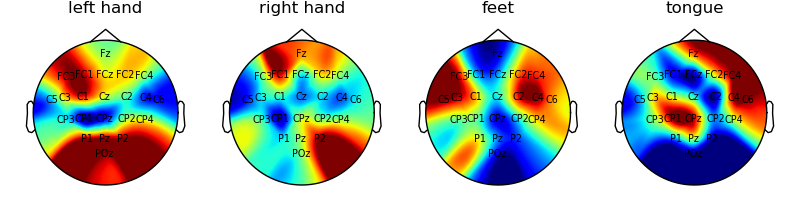

8 Hz


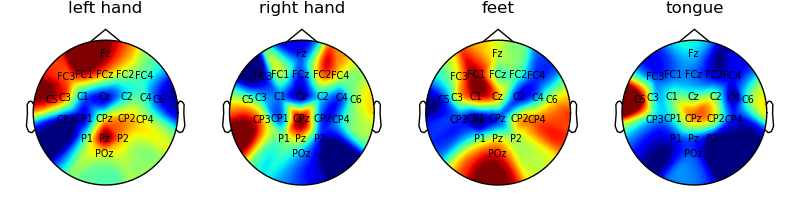

10 Hz


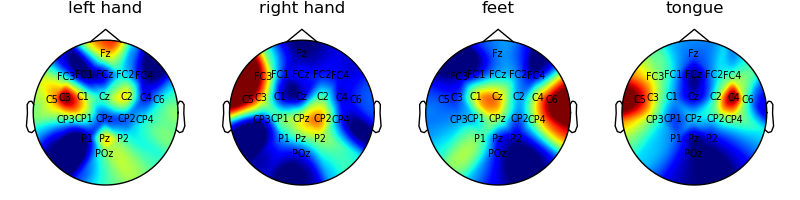

12 Hz


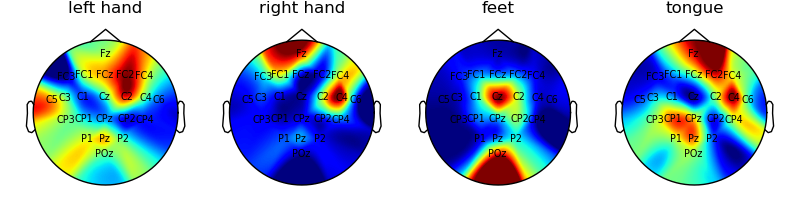

15 Hz


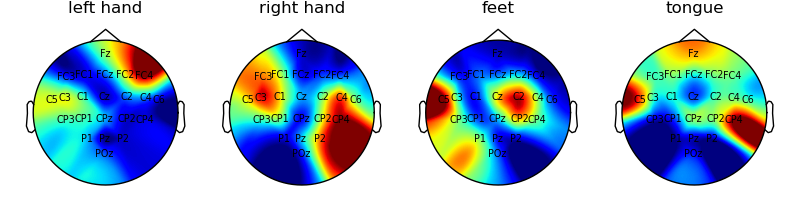

30 Hz


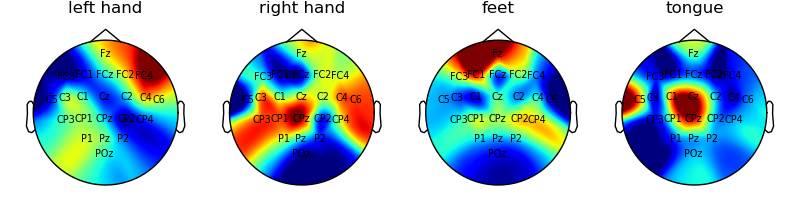

In [26]:
#dic_events = {1:'left hand', 2:'right hand', 3:'feet', 4:'tongue'}
data = wdhtdata
time = np.arange(data.shape[2]) / sfreq
frequency = np.arange(0, data.shape[2]) * (sfreq / data.shape[2])


frequencies = [4,8,10,12,15,30]
for f in frequencies:
    print(f'{f} Hz')
    fig, axes = plt.subplots(1, 4, figsize=(8, 2))
    ax = axes = axes.flatten()
    for idx, i in enumerate(labels[:4]):
        ax = axes[idx]
        mne.viz.plot_topomap(wdhtdata[idx,:,f], raw_signals.info, axes=ax, sensors=False, names=signal_channels, 
                            show=False, sphere=0.08, ch_type="eeg", contours=False, cmap='jet')
        ax.set_title(f'{dic_labels[idx]}')
    plt.tight_layout()
    plt.show()
    #plt.close()

In [27]:
x_train, y_train = wdhtdata.reshape((288, 22*1125)), wlabels
x_test, y_test = wdhtdatatest.reshape((288, 22*1125)), wlabelstest

In [28]:
model_svm = SVC(random_state=0, kernel='linear', C=10,)
model_svm.fit(x_train, y_train)

#predict on training set
y_train_pred = model_svm.predict(x_train)
print(classification_report(y_train, y_train_pred))

#predict on test set
y_test_pred = model_svm.predict(x_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        72
           1       1.00      1.00      1.00        72
           2       1.00      1.00      1.00        72
           3       1.00      1.00      1.00        72

    accuracy                           1.00       288
   macro avg       1.00      1.00      1.00       288
weighted avg       1.00      1.00      1.00       288

              precision    recall  f1-score   support

           0       0.52      0.65      0.58        72
           1       0.48      0.29      0.36        72
           2       0.59      0.61      0.60        72
           3       0.66      0.74      0.70        72

    accuracy                           0.57       288
   macro avg       0.56      0.57      0.56       288
weighted avg       0.56      0.57      0.56       288



#### Training with EEGClassifier

In [136]:
cuda = torch.cuda.is_available()  # check if GPU is available, if True chooses to use it
device = "cuda" if cuda else "cpu"
if cuda:
    torch.backends.cudnn.benchmark = False
seed = 20200220
set_random_seeds(seed=seed, cuda=cuda)

n_classes = 4
classes = list(range(n_classes))
# Extract number of chans and time steps from dataset
n_channels = windows_dataset[0][0].shape[0]
input_window_samples = windows_dataset[0][0].shape[1]

model = EEGNetv1(
    n_channels,
    n_classes,
    n_times=input_window_samples,
    final_conv_length="auto",
    
)

# Display torchinfo table describing the model
print(model)

# Send model to GPU
if cuda:
    model.cuda()

Layer (type (var_name):depth-idx)        Input Shape               Output Shape              Param #                   Kernel Shape
EEGNetv1 (EEGNetv1)                      [1, 22, 1125]             [1, 4]                    --                        --
├─Ensure4d (ensuredims): 1-1             [1, 22, 1125]             [1, 22, 1125, 1]          --                        --
├─Conv2d (conv_1): 1-2                   [1, 22, 1125, 1]          [1, 16, 1125, 1]          368                       [1, 1]
├─BatchNorm2d (bnorm_1): 1-3             [1, 16, 1125, 1]          [1, 16, 1125, 1]          32                        --
├─Expression (elu_1): 1-4                [1, 16, 1125, 1]          [1, 16, 1125, 1]          --                        --
├─Expression (permute_1): 1-5            [1, 16, 1125, 1]          [1, 1, 16, 1125]          --                        --
├─Dropout (drop_1): 1-6                  [1, 1, 16, 1125]          [1, 1, 16, 1125]          --                        --
├─Conv2d (

/home/natalia/miniforge-pypy3/envs/PhD_test/lib/python3.12/site-packages/braindecode/models/base.py:180: UserWarning:

LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!



In [137]:
lr = 0.01 #0.0625 * 0.01 #0.0001
weight_decay = 0.7
batch_size = 10
n_epochs = 100 #50

clf = EEGClassifier(
    model,
    criterion=torch.nn.NLLLoss,
    optimizer=torch.optim.Adam,
    train_split=None,
    optimizer__lr=lr,
    optimizer__weight_decay=weight_decay,
    batch_size=batch_size,
    callbacks=[
        "accuracy",
        ("lr_scheduler", LRScheduler("CosineAnnealingLR", T_max=n_epochs - 1)),
    ],
    device=device,
    classes=classes,
    max_epochs=n_epochs,
)
# Model training for a specified number of epochs. 
clf.fit(np.array(wdhtdata), y=np.array(wlabels))

# evaluated the model after training
y_test = test_set.get_metadata().target
test_acc = clf.score(np.array(wdhtdatatest), y=np.array(wlabelstest))
print(f"Test acc: {(test_acc * 100):.2f}%")

  epoch    train_accuracy    train_loss      lr     dur
-------  ----------------  ------------  ------  ------
      1            0.2500        3.0013  0.0100  0.3635


      2            0.2500        1.3918  0.0100  0.3584
      3            0.2500        1.2074  0.0100  0.3515
      4            0.2500        1.1633  0.0100  0.3548
      5            0.2500        1.1207  0.0100  0.3553
      6            0.2500        1.1656  0.0099  0.3557
      7            0.2500        1.1592  0.0099  0.3553
      8            0.2500        1.1642  0.0099  0.3554
      9            0.2500        1.1548  0.0098  0.3560
     10            0.2500        1.2019  0.0098  0.3560
     11            0.2500        1.2060  0.0098  0.3557
     12            0.3229        1.2205  0.0097  0.3561
     13            0.2604        1.2066  0.0096  0.3559
     14            0.3611        1.1670  0.0096  0.3558
     15            0.2500        1.2067  0.0095  0.3557
     16            0.2500        1.1820  0.0094  0.3561
     17            0.2500        1.2061  0.0094  0.3558
     18            0.3160        1.2168  0.0093  0.3559
     19            0.3854        1.1723  0.0092 